# Analiza ogłoszeń w serwisie otodom.pl

Analiza dotyczy 17000 ogłoszeń z terenu miasta Warszawa; mieszkania - stan na 29.01.2020

<strong>
            <a href='https://www.linkedin.com/in/marianwitkowski/' target="_parent">  Marian Witkowski</a>    </strong>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import geopandas
import zipfile, re, os

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("otomoto-head.csv", sep=';', na_values=['None'])
df = df[df.columns[1:]]
df.head()

,Lp,ID,url,title,rooms,price,price_m2,area,loc
0,1,44lPr,https://www.otodom.pl/oferta/mieszkanie-38-1m-...,"Mieszkanie 38,1m 2 +komórka lokatorska 7,9m2 W...",2,420000.0,11024.0,38.10,"Targówek, Targówek Fabryczny"
1,2,41amC,https://www.otodom.pl/oferta/port-67-ID41amC.h...,Port 67,3,NaN,NaN,66.93,Praga-Północ
2,3,42baq,https://www.otodom.pl/oferta/niepowtarzalny-ap...,"Niepowtarzalny Apartament na Wilanowie, z ogro...",4,1385000.0,13850.0,100.00,Wilanów
3,4,44rv3,https://www.otodom.pl/oferta/3-pokoje-blisko-d...,3 pokoje blisko do centrum Okazja,3,549000.0,10558.0,52.00,Śródmieście
4,5,44rv2,https://www.otodom.pl/oferta/4-5-pokoi-dla-rod...,4-5 pokoi dla Rodziny dskonała lokalizacja -b....,4,979000.0,9790.0,100.00,Śródmieście


In [0]:
def get_district(s):
    items = s.split(",")
    if len(items)==0:
        return s.upper().strip()
    return items[0].upper().strip()

df["district"] = df["loc"].apply(get_district)

In [0]:
df_district = df.groupby('district').size().to_frame()
df_district.columns = ['qnty']
df_district

In [0]:
def read_shape_from_zip(zip_filename, entry_name_regex):
    z = zipfile.ZipFile(zip_filename, mode="r")
    dbf_name = list(filter(
            lambda x: re.match(entry_name_regex + r'.*\.dbf$', os.path.basename(x)), 
            z.namelist()
    ))[0]
    z.close()
    return geopandas.read_file(dbf_name, encoding='utf-8', vfs='zip://'+zip_filename)

In [0]:
# https://gis-support.pl/wp-content/uploads/dzielnice_Warszawy.zip
districts = read_shape_from_zip("dzielnice_Warszawy.zip", "dzielnice_Warszawy")
districts["nazwa_dzie"] = districts["nazwa_dzie"].str.upper()

In [0]:
df_district_qnty = pd.merge(districts, df_district, left_on='nazwa_dzie', right_index=True)
df_district_qnty.sort_values('qnty',ascending=False)

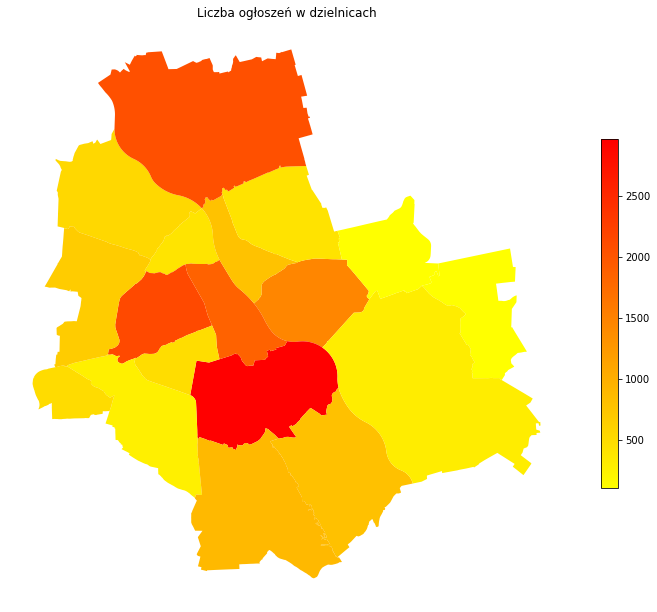

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_qnty.plot(column='qnty', cmap='autumn_r', linewidth=1.5, ax=ax)

vmin, vmax = df_district_qnty['qnty'].min(), df_district_qnty['qnty'].max()
sm = plt.cm.ScalarMappable(cmap='autumn_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(False)
ax.set_axis_off()
ax.set_title("Liczba ogłoszeń w dzielnicach")
plt.tight_layout()
plt.show()

## Wykres rozproszenia - powierzchnia vs cena

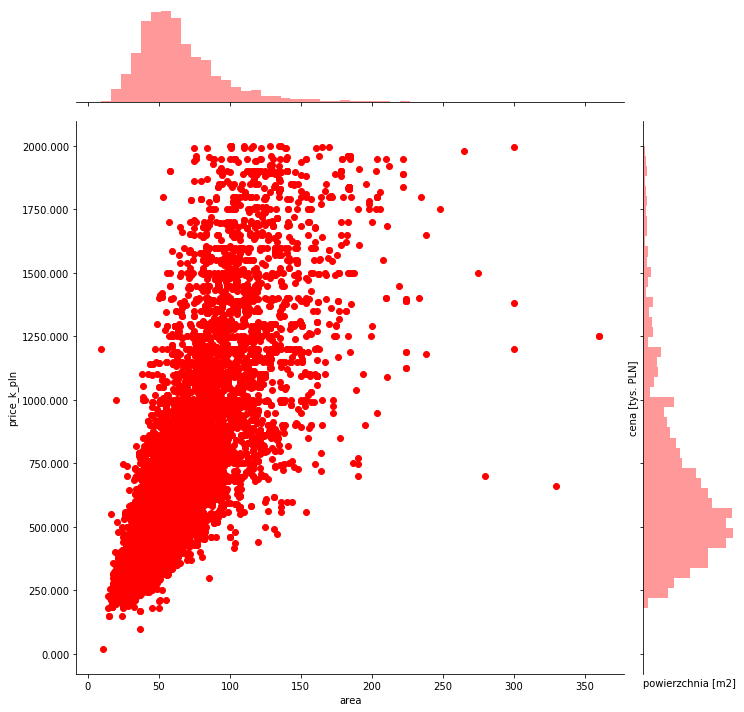

In [9]:
df["price_k_pln"] = df["price"]/1000.0
sns.jointplot(x='area',y='price_k_pln',data=df[(df.area<400) & (df.price<2E6)], 
              height=10, color='red')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
plt.xlabel('powierzchnia [m2]')
plt.ylabel('cena [tys. PLN]')
plt.show()

## Histogram dla liczby pokojów

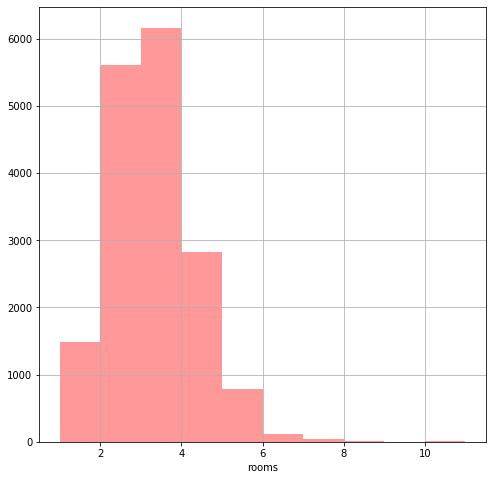

In [10]:
plt.figure(figsize=(8,8))
sns.distplot(df.rooms, bins=10, kde=False, color='red')
plt.grid()

## Histogram dla cena/m2

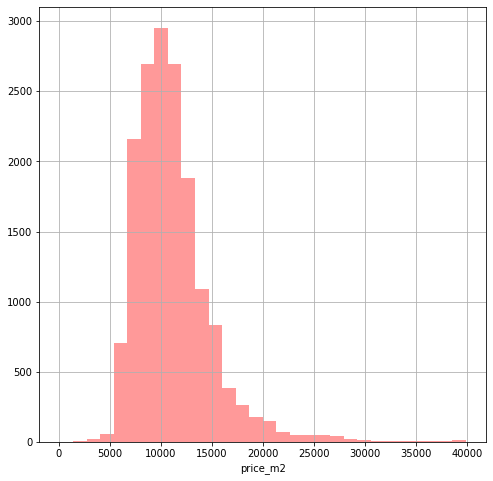

In [11]:
plt.figure(figsize=(8,8))
sns.distplot(df.price_m2[df.price_m2<40000], bins=30, kde=False, color='red')
plt.grid()

## Histogram dla ceny nieruchomości

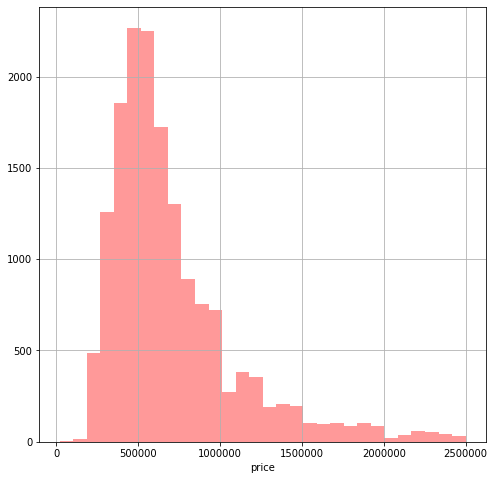

In [12]:
plt.figure(figsize=(8,8))
sns.distplot(df.price[df.price<2500000], bins=30, kde=False, color='red')
plt.grid()

## Liczba ogłoszeń dla poszczególnych dzielnic

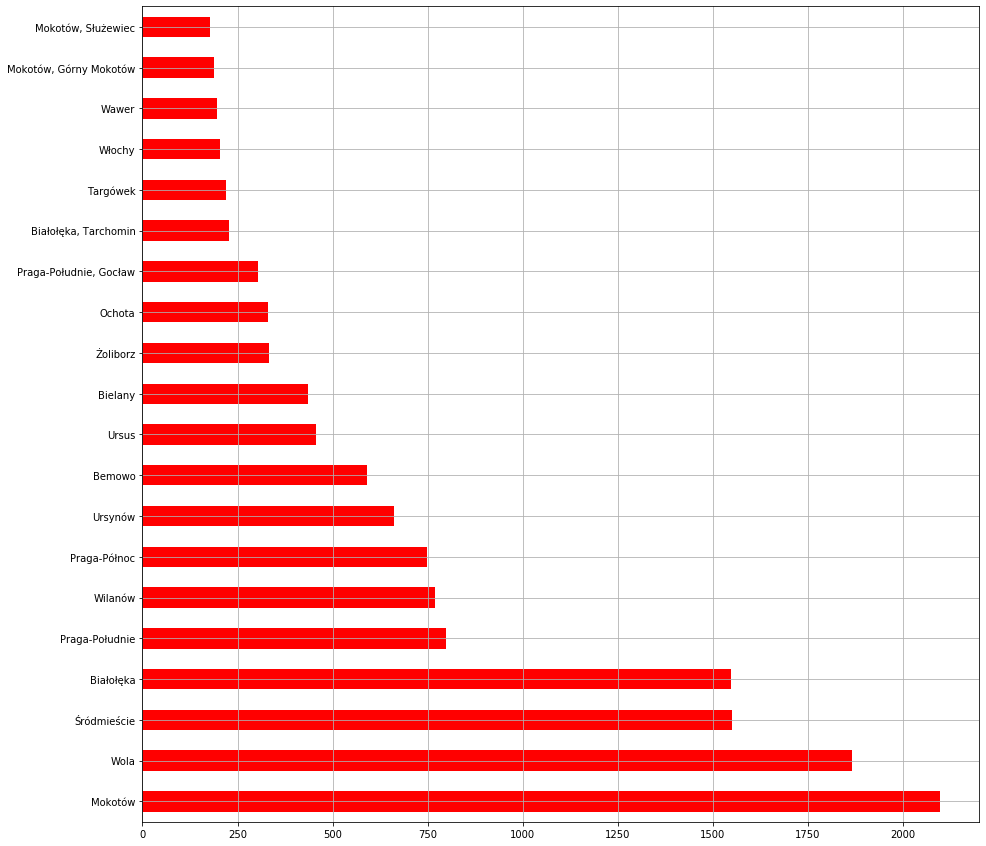

In [13]:
df["loc"].value_counts().sort_values(ascending=False).head(20).plot(kind='barh', 
                                                            figsize=(15,15), color='red', grid=True)
plt.show()

In [14]:
df_feature = pd.read_csv("otomoto-details.csv", sep=';')
del(df_feature["Unnamed: 0"])
del(df_feature["feat_"])
df_feature.head()

,ID,descr,feat_balkon,feat_domofon / wideofon,feat_drzwi / okna antywłamaniowe,feat_internet,feat_pom. użytkowe,feat_telefon,feat_telewizja kablowa,feat_teren zamknięty,ov_Liczba pięter,ov_Liczba pokoi,ov_Piętro,ov_Powierzchnia,ov_Rodzaj zabudowy,ov_Rynek,ov_Czynsz,ov_Dostępne od,ov_Forma własności,ov_Materiał budynku,ov_Ogrzewanie,ov_Okna,ov_Rok budowy,ov_Stan wykończenia,feat_garaż/miejsce parkingowe,feat_ogródek,feat_piwnica,feat_taras,feat_winda,feat_monitoring / ochrona,feat_system alarmowy,feat_klimatyzacja,feat_oddzielna kuchnia,feat_kuchenka,feat_meble,feat_piekarnik,feat_lodówka,feat_zmywarka,feat_pralka,feat_dwupoziomowe,feat_telewizor,feat_rolety antywłamaniowe
0,43E0a,BEZPOŚREDNIO/ 0% PROWIZJI / BEZ PODATKU PCCWyj...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3,1,67 m²,dom wolnostojący,pierwotny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,440aD,Sprzedam dwupokojowe mieszkanie (39 mkw) w Śró...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,3.0,2,parter,"39,10 m²",kamienica,wtórny,240 zł,2019-12-23,pełna własność,cegła,miejskie,plastikowe,1948.0,do zamieszkania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44qDX,Tarchomin-Nowodwory ul.Odkryta/Hanki Ordonówny...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3,parter,77 m²,apartamentowiec,wtórny,718 zł,NaN,NaN,cegła,miejskie,plastikowe,2012.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44noR,Zapraszam na prezentację lokalu w najbliższą n...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,8.0,3,3,"76,80 m²",apartamentowiec,wtórny,480 zł,NaN,NaN,cegła,miejskie,NaN,2009.0,do remontu,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3RekE,Klimat Saskiej Kępy\nSaska Kępa to jedna z naj...,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,2.0,3,1,106 m²,apartamentowiec,pierwotny,NaN,NaN,pełna własność,NaN,miejskie,NaN,2018.0,do wykończenia,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
cols = list(["ID","descr"])
cols.extend( list(sorted(df_feature.columns[2:])) )
df_feature = df_feature[cols]
df_feature.head()

,ID,descr,feat_balkon,feat_domofon / wideofon,feat_drzwi / okna antywłamaniowe,feat_dwupoziomowe,feat_garaż/miejsce parkingowe,feat_internet,feat_klimatyzacja,feat_kuchenka,feat_lodówka,feat_meble,feat_monitoring / ochrona,feat_oddzielna kuchnia,feat_ogródek,feat_piekarnik,feat_piwnica,feat_pom. użytkowe,feat_pralka,feat_rolety antywłamaniowe,feat_system alarmowy,feat_taras,feat_telefon,feat_telewizja kablowa,feat_telewizor,feat_teren zamknięty,feat_winda,feat_zmywarka,ov_Czynsz,ov_Dostępne od,ov_Forma własności,ov_Liczba pięter,ov_Liczba pokoi,ov_Materiał budynku,ov_Ogrzewanie,ov_Okna,ov_Piętro,ov_Powierzchnia,ov_Rodzaj zabudowy,ov_Rok budowy,ov_Rynek,ov_Stan wykończenia
0,43E0a,BEZPOŚREDNIO/ 0% PROWIZJI / BEZ PODATKU PCCWyj...,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,3,NaN,NaN,NaN,1,67 m²,dom wolnostojący,NaN,pierwotny,NaN
1,440aD,Sprzedam dwupokojowe mieszkanie (39 mkw) w Śró...,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240 zł,2019-12-23,pełna własność,3.0,2,cegła,miejskie,plastikowe,parter,"39,10 m²",kamienica,1948.0,wtórny,do zamieszkania
2,44qDX,Tarchomin-Nowodwory ul.Odkryta/Hanki Ordonówny...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,718 zł,NaN,NaN,5.0,3,cegła,miejskie,plastikowe,parter,77 m²,apartamentowiec,2012.0,wtórny,NaN
3,44noR,Zapraszam na prezentację lokalu w najbliższą n...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,480 zł,NaN,NaN,8.0,3,cegła,miejskie,NaN,3,"76,80 m²",apartamentowiec,2009.0,wtórny,do remontu
4,3RekE,Klimat Saskiej Kępy\nSaska Kępa to jedna z naj...,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,pełna własność,2.0,3,NaN,miejskie,NaN,1,106 m²,apartamentowiec,2018.0,pierwotny,do wykończenia


In [0]:
for col in df_feature.columns[2:]:
    if pd.api.types.is_numeric_dtype(df_feature[col]):
        df_feature[col].replace(pd.np.NaN, 0, inplace=True)
        df_feature[col] = df_feature[col].astype('int')
    
    if pd.api.types.is_string_dtype(df_feature[col]):
        df_feature[col].replace(pd.np.NaN, "", inplace=True)


In [17]:
df_feature.columns

Index(['ID', 'descr', 'feat_balkon', 'feat_domofon / wideofon',
       'feat_drzwi / okna antywłamaniowe', 'feat_dwupoziomowe',
       'feat_garaż/miejsce parkingowe', 'feat_internet', 'feat_klimatyzacja',
       'feat_kuchenka', 'feat_lodówka', 'feat_meble',
       'feat_monitoring / ochrona', 'feat_oddzielna kuchnia', 'feat_ogródek',
       'feat_piekarnik', 'feat_piwnica', 'feat_pom. użytkowe', 'feat_pralka',
       'feat_rolety antywłamaniowe', 'feat_system alarmowy', 'feat_taras',
       'feat_telefon', 'feat_telewizja kablowa', 'feat_telewizor',
       'feat_teren zamknięty', 'feat_winda', 'feat_zmywarka', 'ov_Czynsz',
       'ov_Dostępne od', 'ov_Forma własności', 'ov_Liczba pięter',
       'ov_Liczba pokoi', 'ov_Materiał budynku', 'ov_Ogrzewanie', 'ov_Okna',
       'ov_Piętro', 'ov_Powierzchnia', 'ov_Rodzaj zabudowy', 'ov_Rok budowy',
       'ov_Rynek', 'ov_Stan wykończenia'],
      dtype='object')

## Występowanie windy

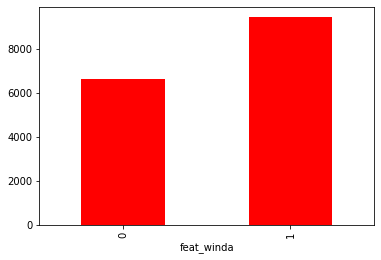

In [18]:
df_feature.groupby("feat_winda").size().plot(kind='bar',color='red')
plt.show()

## Występowanie oddzielnej kuchni

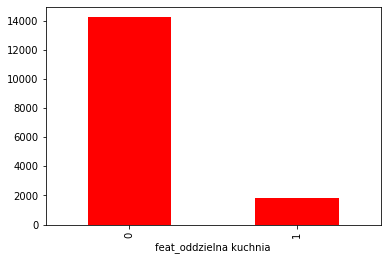

In [19]:
df_feature.groupby("feat_oddzielna kuchnia").size().plot(kind='bar',color='red')
plt.show()

## Występowanie klimatyzacji

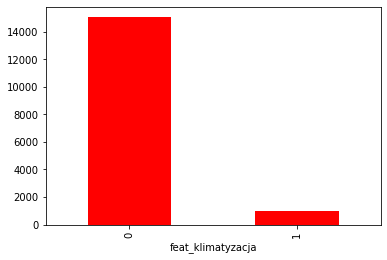

In [20]:
df_feature.groupby("feat_klimatyzacja").size().plot(kind='bar',color='red')
plt.show()

## Rok budowy budynku

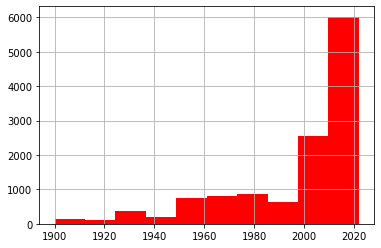

In [21]:
df_feature[df_feature["ov_Rok budowy"]>=1900]["ov_Rok budowy"].sort_values().hist(color='red')
plt.show()

In [0]:
df_feature.replace("","brak danych", inplace=True)

def czynsz(s):
    try:
        return float(s.replace(" ","").replace("zł","").replace(",","."))
    except:
        return pd.np.NaN

df_feature["ov_Czynsz"] = df_feature["ov_Czynsz"].apply(czynsz)

## Rozkład kwotu czynszu

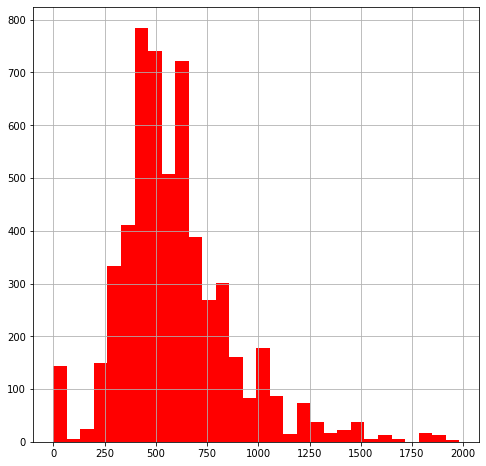

In [23]:
max_range = df_feature["ov_Czynsz"].quantile(0.99)
df_feature[(df_feature.ov_Czynsz<max_range) & (df_feature.ov_Czynsz>0)]["ov_Czynsz"].\
                                               hist(bins=30, color='red', figsize=(8,8))
plt.show()

## Liczba ogłoszeń dla danej formy własności

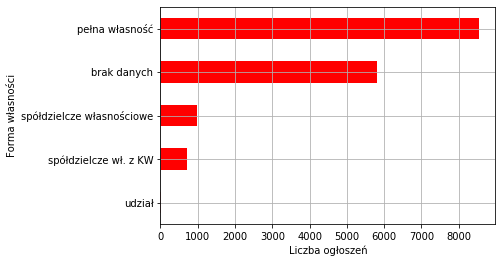

In [24]:
df_feature.groupby("ov_Forma własności")["ID"].size().sort_values().plot(kind='barh', grid=True, color='red')
plt.xlabel('Liczba ogłoszeń')
plt.ylabel('Forma własności')
plt.show()

## Liczba ogłoszeń dla danej liczby pokojów

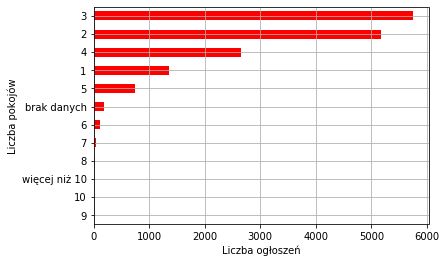

In [25]:
df_feature["ov_Liczba pokoi"].value_counts().sort_values().plot(kind='barh', grid=True, color='red')
plt.xlabel('Liczba ogłoszeń')
plt.ylabel('Liczba pokojów')
plt.show()

In [26]:
df = pd.read_csv("otomoto-details-dates.csv", sep=';', 
                 na_values=['?'], usecols=['ID','add_date','update_date'])
df.head()                 

,ID,add_date,update_date
0,43E0a,2019-12-01,2020-01-26
1,440aD,2020-01-01,2020-01-26
2,44qDX,2020-01-31,2020-01-31
3,44noR,2020-01-27,2020-02-01
4,3RekE,2019-02-01,2020-01-15


## Rozkład dat zamieszczenia ogłoszenia (RRRR-MM)

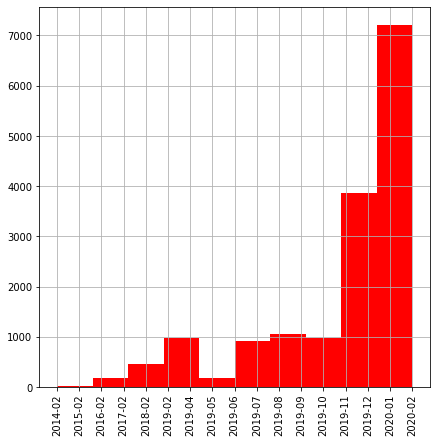

In [27]:
df["add_date"].sort_values().str[:7].hist(xrot=90, figsize=(7,7), color='red')
plt.show()

In [0]:
los =df.ID.sample(300).values

In [0]:
t1 = pd.read_csv("otomoto-head.csv", sep=";")
t1[ t1.ID.isin(los) ].to_csv("otomoto-head-sample.csv", sep=";")

In [0]:
t1 = pd.read_csv("otomoto-details.csv", sep=";")
t1[ t1.ID.isin(los) ].to_csv("otomoto-details-sample.csv", sep=";")

In [0]:
t1 = pd.read_csv("otomoto-details-dates.csv", sep=";")
t1[ t1.ID.isin(los) ].to_csv("otomoto-details-dates-sample.csv", sep=";")